In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, InputLayer, Embedding, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import random

In [121]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [0]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()

In [0]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [0]:
sent_train, sent_test, tag_train, tag_test = train_test_split(sentences, sentence_tags, test_size=0.2, random_state=0)

In [0]:
vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)

In [0]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [127]:
len(filtered_vocab)

1679

In [0]:
word2id = {'PAD':0,'UNK':1}    
for i,word in enumerate(filtered_vocab):
      word2id[word] = i + 2
id2word = {i:word for word, i in word2id.items()}

In [129]:
len(id2word)

1681

In [0]:
tag2id = {'PAD':0}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [0]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
          try:
            int_seq.append(smth2id[i.lower()])
          except KeyError:
            int_seq.append(smth2id['UNK'])
  
      int_data.append(int_seq)
  return int_data

In [0]:
X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)


In [0]:
MAX_LEN = max(len(x) for x in sent_train)

In [0]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=MAX_LEN, padding='post'), pad_sequences(X_test_ids, maxlen=MAX_LEN, padding='post')
y_train_pad, y_test_pad = pad_sequences(y_train_ids, maxlen=MAX_LEN, padding='post'), pad_sequences(y_test_ids, maxlen=MAX_LEN, padding='post')

In [135]:
print(X_train.shape, y_train_pad.shape, X_test.shape, y_test_pad.shape)

(3131, 128) (3131, 128) (783, 128) (783, 128)


In [0]:
y_train, y_test = to_categorical(y_train_pad, num_classes=len(tag2id)), to_categorical(y_test_pad, num_classes=len(tag2id))

#Добавим второй входной слой

In [138]:
chars_vocab = Counter()
for sent in sent_train:
  for word in sent:
    sent = [char.lower() for char in word]
    chars_vocab.update(sent)
len(chars_vocab)

52

In [139]:
max_char_len = 0
for sentence in sent_train:
  max_len = max(len(word) for word in sentence)
  max_char_len = max(max_char_len, max_len)
max_char_len

24

In [140]:
max_seq_len = max(len(sent) for sent in sent_train)
max_seq_len

128

In [0]:
char2id = {'PAD':0,'UNK':1} 
for i, char in enumerate(chars_vocab):
  char2id[char] = i + 2
id2char = {i:char for char, i in char2id.items()}

In [0]:
def char2ints(data, smth2id):
  int_data = []
  for sent in data:
    int_seq = []
    for w in range(max_seq_len):
      word_seq = []
      for ch in range(max_char_len):
        try:
          character = smth2id.get(sentence[w][ch])
          if type(sentence[w][ch]) == str:
            character = smth2id.get(sentence[w][ch].lower())
          word_seq+=[character]
        except IndexError:
          word_seq+=[0]
        except KeyError:
          word_seq+=[1]
      int_seq+=[word_seq]
    int_data+=[np.array(int_seq)]
  return int_data

In [0]:
X_train_ids_char, X_test_ids_char = char2ints(sent_train, char2id), char2ints(sent_test, char2id)
X_train_char, X_test_char = pad_sequences(X_train_ids_char, maxlen=max_seq_len, padding='post'), pad_sequences(X_test_ids_char, maxlen=max_seq_len, padding='post')

In [160]:
print(X_train_char.shape,X_train.shape, y_train.shape, X_test_char.shape, X_test.shape, y_test.shape)

(3131, 128, 24) (3131, 128) (3131, 128, 47) (783, 128, 24) (783, 128) (783, 128, 47)


In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel', 
                                                monitor='accuracy',
                                                verbose=1, 
                                                save_weights_only=False,
                                                save_best_only=True, 
                                                mode='max',
                                                save_freq='epoch'
                                               )

In [0]:
input_sent = tf.keras.layers.Input(shape=(max_seq_len,))
emb_sent = Embedding(input_dim=len(word2id), output_dim=50, mask_zero=True) (input_sent)
lstm_sent = Bidirectional(LSTM(256, return_sequences=True)) (emb_sent)
drop = Dropout(0.2)

input_char = tf.keras.layers.Input(shape=(max_seq_len, max_char_len,))
emb_char = TimeDistributed(Embedding(input_dim=len(char2id), output_dim=50))(input_char)
conv = TimeDistributed(Conv1D(kernel_size=10, filters=32, strides=1))(emb_char)
flat = TimeDistributed(tf.keras.layers.Flatten())(conv)

concat = tf.keras.layers.concatenate([lstm_sent, flat])
lstm = Bidirectional(LSTM(256, return_sequences=True)) (concat)
dense = TimeDistributed(Dense(len(tag2id), activation="sigmoid"))(lstm)

model = tf.keras.Model([input_sent, input_char], dense)

In [174]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 24)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 128, 24, 50)  2700        input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 128, 50)      84050       input_3[0][0]                    
____________________________________________________________________________________________

In [177]:
model.fit([X_train, X_train_char], y_train, validation_data=([X_test, X_test_char], y_test), batch_size=200, epochs=30)

Epoch 1/30
16/16 [==============================] - 216s 14s/step - loss: 0.5979 - accuracy: 0.0260 - val_loss: 0.6080 - val_accuracy: 0.0272
Epoch 2/30
16/16 [==============================] - 213s 13s/step - loss: 0.5845 - accuracy: 0.0279 - val_loss: 0.5969 - val_accuracy: 0.0342
Epoch 3/30
16/16 [==============================] - 214s 13s/step - loss: 0.5736 - accuracy: 0.0335 - val_loss: 0.5885 - val_accuracy: 0.0354
Epoch 4/30
16/16 [==============================] - 212s 13s/step - loss: 0.5673 - accuracy: 0.0346 - val_loss: 0.5883 - val_accuracy: 0.0361
Epoch 5/30
16/16 [==============================] - 213s 13s/step - loss: 0.5635 - accuracy: 0.0349 - val_loss: 0.5807 - val_accuracy: 0.0364
Epoch 6/30
16/16 [==============================] - 213s 13s/step - loss: 0.5573 - accuracy: 0.0355 - val_loss: 0.5777 - val_accuracy: 0.0389
Epoch 7/30
16/16 [==============================] - 216s 13s/step - loss: 0.5507 - accuracy: 0.0364 - val_loss: 0.5746 - val_accuracy: 0.0419
Epoch 

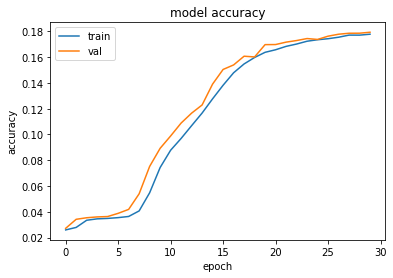

In [179]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
def pos_pred(sentences): # предсказания сети для случайного предложения из списка
  r = random.randint(0, len(sentences))
  sentence = sentences[r]
  sent_ints = data2ints(sentence, word2id)
  sent_ints_pad = pad_sequences(sent_ints, maxlen=max_seq_len, padding='post')
  sent_ints_char = char2ints(sentence, char2id)
  sent_ints_char_pad = pad_sequences(sent_ints_char, maxlen=max_seq_len, padding='post')
  pred = model.predict([sent_ints_pad, sent_ints_char_pad])
  tags = np.argmax(pred[1], axis=-1)
  for word, tag in zip(sentence, tags):
      print(word, id2tag[tag])

In [455]:
pos_pred(sent_test)

The nnp
record nnp
corn-buying jj
binge jj
by nnp
the .
Soviet sym
Union sym
is sym
causing sym
serious sym
bottlenecks sym
in sym
the sym
U.S. sym
grain sym
pipeline sym
. sym


In [457]:
pos_pred(sent_test)

Many prp
institutional rb
index jj
funds rb
are prp
active jj
program jj
traders nns
, prp
*-1 rb
swapping vbg
their dt
stocks nn
for sym
futures sym
when sym
profitable sym
* sym
to sym
do sym
so sym
*T*-2 sym
. sym


In [463]:
pos_pred(sent_test)

I nnp
believe nnp
in nnp
the prp
system jj
. jj


In [468]:
pos_pred(sent_test)

The nnp
loudest nnp
of nnp
these jj
reformers jj
are nnp
money .
managers sym
who sym
*T*-77 sym
cater sym
to sym
smaller sym
investors sym
. sym
